In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk

In [32]:
# the interchange of window axis to image axis
e2c = lambda e, c: (c.canvasx(e.x), c.canvasy(e.y))


#function to be called when mouse is clicked
def print_pos(e):
    #outputting x and y coords to console
    cx, cy = e2c(e, canvas)
    click = [e.y, e.x, cy, cx]
    print("(%d, %d) / (%d, %d)" % (e.y, e.x, cy, cx))
    nodes.append(click)
    i = len(nodes)
    canvas.create_text(300 + i * 50, 670, text="(%d,%d)" % (e.y, e.x), font=("Arial", 10))


# build a window object
loc = Tk()

#box for points
nodes = []

#size of the window
loc.geometry("900x700")
loc.title("CA1 Part4")
canvas = Canvas(loc, bg='white', width=900, height=700)
canvas.pack()

#adding the image
img_im1 = Image.open('./img/im01.jpg')
img_im1_photo = ImageTk.PhotoImage(img_im1)
img_im2 = Image.open('./img/im02.jpg')
img_im2_photo = ImageTk.PhotoImage(img_im2)

img_canvas = canvas.create_image(0, 0, image=img_im1_photo, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))
text_canvas = canvas.create_text(200, 620, text="Click 4 points on im1", font=("Arial", 20))
canvas.create_text(180, 670, text="Position of points:", font=("Arial", 20))

#mouseclick event
canvas.bind("<ButtonPress-1>", print_pos)


# set button event
def change_img():
    canvas.itemconfig(img_canvas, image=img_im2_photo)
    canvas.itemconfig(text_canvas, text="Click 4 points on im2")


# set button 
button = Button(loc, text='Next img', command=change_img)
button.place(x=750, y=650)

# start
loc.mainloop()

(228, 314) / (225, 311)
(244, 623) / (241, 620)
(465, 304) / (462, 301)
(477, 627) / (474, 624)
(210, 14) / (207, 11)
(234, 345) / (231, 342)
(473, 6) / (470, 3)
(474, 360) / (471, 357)


In [33]:
# homography computing
def homography(points):
    A = np.zeros([8, 9])
    b = []
    for i in range(0, 4):
        h1_x = points[i][2]
        h1_y = points[i][3]
        h2_x = points[i + 4][2]
        h2_y = points[i + 4][3]
        A[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        A[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]

    _, _, vt = np.linalg.svd(A)
    H = vt[-1].reshape(3, 3)
    H = H / H[2, 2]  # H(3,3) = 1

    return H


# the H
H = homography(nodes)
print(H)


# transform h1 to h2
def size_shape(h1, H):
    [row, col, c] = h1.shape

    # 4 cornor of the image h1
    lt = np.array([[0, 0, 1]])
    rt = np.array([[0, col, 1]])
    lb = np.array([[row, 0, 1]])
    rb = np.array([[row, col, 1]])

    # edge matrix
    edge = np.concatenate((lt, rt, lb, rb), axis=0).T

    T_edge = np.dot(H, edge)
    # normalize
    T_edge = T_edge[0:2, :] / T_edge[2, :]
    T_edge = T_edge

    return np.max(T_edge[0, :]), np.min(T_edge[0, :]), np.max(T_edge[1, :]), np.min(T_edge[1, :])


[[ 1.12131807e+00  8.35758242e-02 -5.93651874e+01]
 [ 1.54284939e-02  1.22018258e+00 -3.71314581e+02]
 [-1.07692042e-04  2.63125268e-04  1.00000000e+00]]


In [34]:
# import the image
im1 = cv2.imread('./img/im01.jpg', cv2.IMREAD_COLOR)
im2 = cv2.imread('./img/im02.jpg', cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [35]:
# build a canvas
def get_canvas(im1, im2, Hi):
    # Hi is im2 to im1
    [row1, col1, c] = im1.shape
    [row2, col2, c] = im2.shape

    # get the edge
    [x_max, x_min, y_max, y_min] = size_shape(im2, Hi)
    print([x_min, x_max, y_min, y_max])
    x_minus = int(np.min([0, x_min]) - 1)
    x_plus = int(np.max([0, x_max - row1]) + 1)
    y_minus = int(np.min([0, y_min]) - 1)
    y_plus = int(np.max([0, y_max - col1]) + 1)

    # x direction adding space
    add_x_minus = np.zeros([-x_minus, col1, c])
    add_x_plus = np.zeros([x_plus, col1, c])

    # y direction adding space
    add_y_minus = np.zeros([-x_minus + row1 + x_plus, -y_minus, c])
    add_y_plus = np.zeros([-x_minus + row1 + x_plus, y_plus, c])

    # concatenate the adding space with im1
    canvas = np.concatenate((add_x_minus, im1, add_x_plus), axis=0)
    canvas = np.concatenate((add_y_minus, canvas, add_y_plus), axis=1)

    return canvas.astype(int), [x_minus, y_minus]


[-18.83610861298584, 493.3930299665888, 298.3591991970281, 963.0351492940921]
[-19, -1]


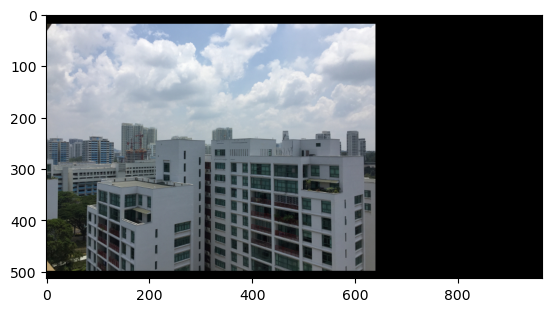

In [36]:
# im2 to im1
Hi = np.linalg.inv(H)

# get canvas and axis compensation
canvas, compensation = get_canvas(im1, im2, Hi)

print(compensation)
plt.imshow(canvas)

In [37]:
# transfer m2 to m1
def trans_im22im1(canvas, im2, Hi, compensation):
    # the wight of the im1 when overlay
    w = 0.6

    # step of the transmitting 1/step
    step = 2
    [row, col, c] = im2.shape

    # draw im2 on the canvas
    for j in range(0, row * step):
        for k in range(0, col * step):
            # positon: points of im2 in im1 plane 
            p = np.array([[j / step, k / step, 1]]).T
            Tp = np.dot(Hi, p)

            # normalize and move the image
            x2 = int(round(Tp[0, 0] / Tp[2, 0]) - compensation[0])
            y2 = int(round(Tp[1, 0] / Tp[2, 0]) - compensation[1])

            # position in im1
            x1 = int(j / step)
            y1 = int(k / step)

            if np.any(canvas[x2, y2] > 0):
                canvas[x2, y2] = w * canvas[x2, y2][:] + (1 - w) * im2[x1, y1][:]
            else:
                canvas[x2, y2] = im2[x1, y1][:]

    return canvas.astype(int)


In [38]:
# Interpolation process to fill the blank
def interpolation(image, size):
    [row, col, c] = image.shape
    valid_pixels = image[~np.isnan(image)]  # catch the valid pixels
    default_val = int(np.mean(valid_pixels)) if valid_pixels.size else 0  # cumpute the mean of valid pixels

    for j in range(0, row):
        for k in range(0, col):
            if np.all(np.isnan(image[j, k]) | (image[j, k] == 0)):  # check if NaN or 0
                for n in range(0, c):
                    r_start, r_end = max(j - size, 0), min(j + size + 1, row)
                    c_start, c_end = max(k - size, 0), min(k + size + 1, col)

                    sub_array = image[r_start:r_end, c_start:c_end, n]
                    avg_val = np.nanmean(sub_array)  # use np.nanmean to ignore NaN values

                    if np.isnan(avg_val):  # if NaN，use default value
                        avg_val = default_val

                    image[j, k, n] = int(avg_val)

    return image


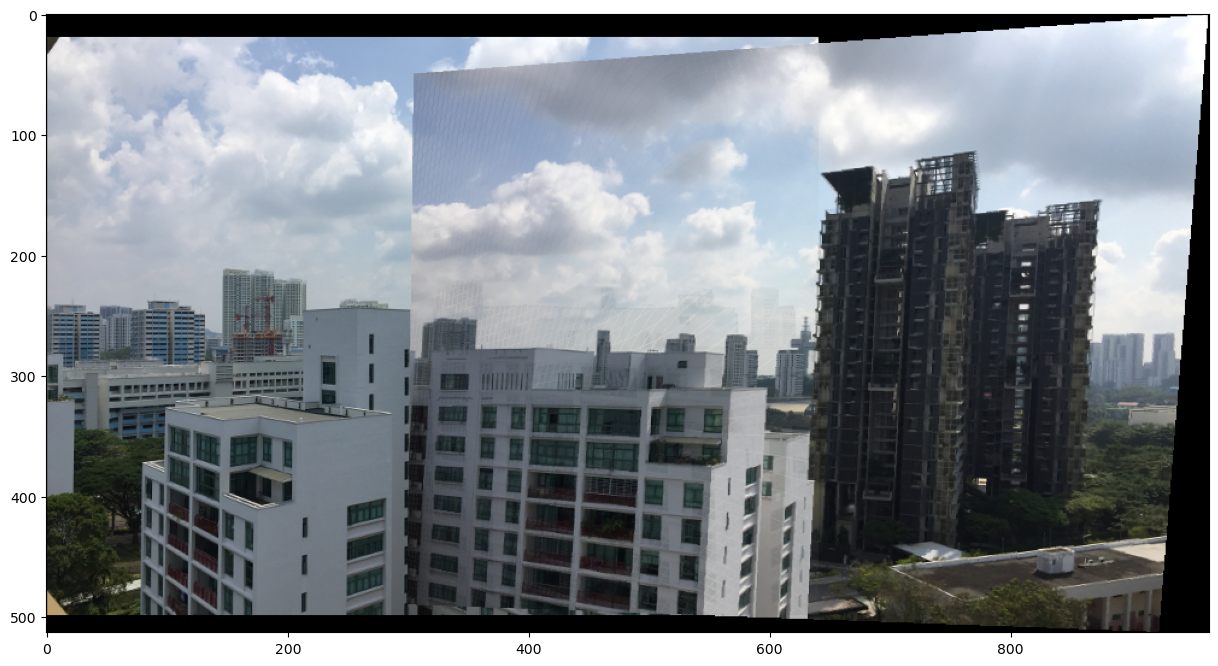

In [39]:
# transfer im2 to im1 plane
Tim = trans_im22im1(canvas, im2, Hi, compensation)
# show the stitched image
plt.figure(figsize=(15, 15))
plt.imshow(Tim)


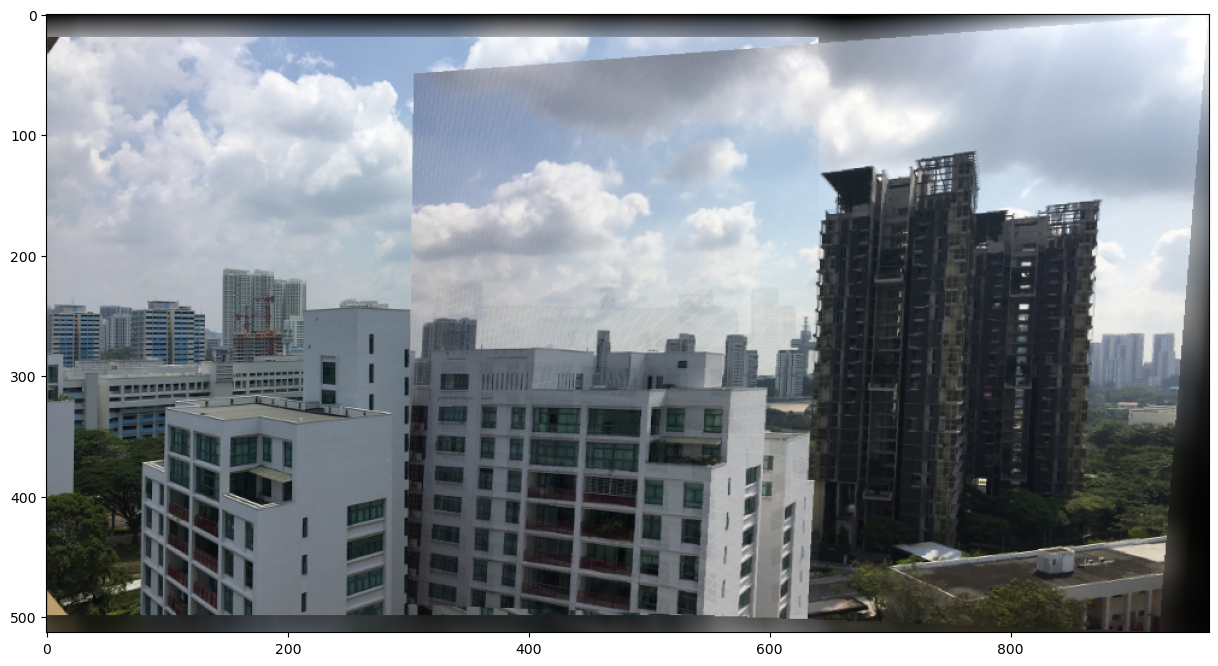

In [41]:
# Tim_in = interpolation1(Tim, 20)
# plt.figure(figsize=(15, 15))
# plt.imshow(Tim_in)
Tim_in = interpolation(Tim, 20)
plt.figure(figsize=(15, 15))
plt.imshow(Tim_in)

## Because the points we choose in im01 and im02 are not the same point in the reality. There is small error. For instance, there is a point in im01 named p1 and its corresponding point in im2 named p2. The real position of p2 in im01 is (p2x,p2y) and the computed p2 position via homography is (p2x+x_error,p2y+y_error). Therefore, the double edges appear. Actually, due to the distinguishability of image is not ifinity. So the error always exists.